We're going to make a map of Antarctic dh/dt.  The tool for this today will be the pointCollection package (available from https://github.com/smithB/pointCollection.git).  You'll want to clone the repository into someplace that's in your python path.  The main useful thing that the ATL11 data class in the repo is to read the essential fields from an ATL11 file, and set the elements marked as invalid to NaN.

In [68]:
# imports:
import glob
import matplotlib.pyplot as plt
import pointCollection as pc
import numpy as np
import h5py
import time
import os

sec_per_year=3600*24*365.25

In [2]:
# setup for the plot
# we can save some typing by defining the cycles in advance:
cycles=[3, 4, 5, 6]
# We'll want to reduce the memory load by skipping some of the ATL11 reference points
n_skip=20
# here is where I store my ATL11s.  You should replace this with your own directory
thedir='/Volumes/ice2/ben/scf/AA_11/U07'
# get a list of files
files=glob.glob(thedir+'/ATL11*.h5')

Let's read just one pair from an ATL11 and see what it looks like.  We're specifying index_range=[0, -1, 1], which means that we read the whole file from the first (0) record to the last (-1), in steps of 1.  

In [56]:
D11=pc.ATL11.data().from_h5(files[0], pair=2, index_range=[0, -1, 1])
print(D11)

<class 'pointCollection.ATL11.data.data'> with shape (17914, 4),
with fields:
['latitude', 'longitude', 'h_corr', 'h_corr_sigma', 'h_corr_sigma_systematic', 'delta_time', 'quality_summary', 'ref_pt', 'dem_h', 'cycle_number']


A pointCollection.ATL11.data object has fields that are $n_{points} \times n_{cycles}$ numpy arrays.  The columns of the fields represent different cycles, the rows different reference points. The 'shape' attribute of the object tells you how many there are of each. There are a lot of fields in an ATL11, but I've picked the ones I use most often.  Let's plot one of these and see what it looks like:

Text(0.5, 1.0, 'ATL11_087610_0306_02_vU07.h5:subset')

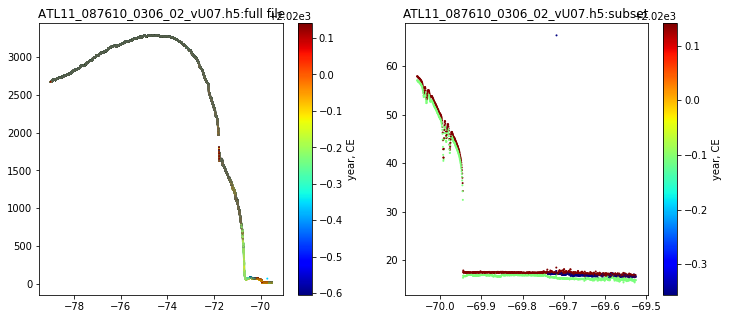

In [71]:
plt.figure(figsize=[12, 5])
plt.subplot(121)
plt.scatter(D11.latitude, D11.h_corr, 4, c=D11.delta_time/sec_per_year+2018, linewidth=0, cmap='jet'); 
plt.colorbar(label='year, CE')
plt.title(os.path.basename(files[0])+":full file")
plt.subplot(122)
plt.scatter(D11.latitude[0:1000,:], D11.h_corr[0:1000,:], 4, c=D11.delta_time[0:1000,:]/sec_per_year+2018, linewidth=0, cmap='jet'); 
plt.colorbar(label='year, CE')
plt.title(os.path.basename(files[0])+":subset")

There are 4000-odd files, so plotting 17000 points per file is not going to work well.  We'll downsample the files as we read them so that the main plot we're trying to make here happens in a reasonable amount of time.  There are also some files that produce errors when we try to read them, so we'll wrap the reading statement in a 'try' clause, and just spit out the name of any files that failed.

In this loop, we build a list of data objects, one for each pair in each file.  Although this is not what I would expect from a Python script, it helps quite a bit to preallocate an empty list and fill it in one entry at a time, rather than just appending each new item onto the end of the list (try it and see!).  We're also adding a field to each object that specifies the file from which it came, so that we can go back and look if we see something cool later on.

On my computer, this takes a while to run.  Now might be a good time for a cup of tea.  If you're in a hurry, change the 'enumerate(files)' to 'enumerate(files[0:500])', which should happen relatively quickly

In [31]:
D11_list=[]
data_count=0
t0=time.time()
D11=[None]* (3*len(files))
for file_count, file in enumerate(files):
    try:
        for pair in [1, 2, 3]:
            temp=pc.ATL11.data().from_h5(file, pair=pair, index_range=[0, -1, n_skip])
            # reject zero-size objects
            if np.min(temp.shape)==0:
                continue
            temp.assign({'file_ind':np.zeros_like(temp.h_corr)+file_count})
            D11[data_count]=temp
            data_count +=1
    except Exception:
        print(f"problem with {file}")
        continue
    # report the time to read the last batch of files
    if np.mod(file_count+1, 250)==0:
        print(f'{file_count} out of {len(files)}, dt={time.time()-t0:2.2f}')
        t0=time.time()
        

249 out of 4159, dt=52.61
499 out of 4159, dt=17.57
749 out of 4159, dt=76.30
problem with /Volumes/ice2/ben/scf/AA_11/U07/ATL11_014512_0306_02_vU07.h5
999 out of 4159, dt=109.62
1249 out of 4159, dt=105.82
1499 out of 4159, dt=107.33
1749 out of 4159, dt=102.34
1999 out of 4159, dt=94.38
2249 out of 4159, dt=110.23
2499 out of 4159, dt=109.28
2749 out of 4159, dt=107.47
2999 out of 4159, dt=104.91
3249 out of 4159, dt=100.03
3499 out of 4159, dt=99.42
3749 out of 4159, dt=100.94
3999 out of 4159, dt=105.85


If you've run everything, D11 now contains around 12000 pointCollection.ATL11 objects.  Let's put them together into just one object, and calculate projected coordinates. After this step, the fact that these were read as pointCollection.ATL11 data objects is lost, and they will now just be treated as pointCollection.data objects.  The difference isn't all that important for now.

In [34]:
D11=pc.data(columns=len(cycles)).from_list(D11[0:data_count])
D11.get_xy(EPSG=3031)
print(D11)

<class 'pointCollection.data.data'> with shape (13575847, 4),
with fields:
['cycle_number', 'file_ind', 'ref_pt', 'quality_summary', 'h_corr_sigma_systematic', 'dem_h', 'h_corr', 'h_corr_sigma', 'delta_time', 'longitude', 'latitude', 'x', 'y']


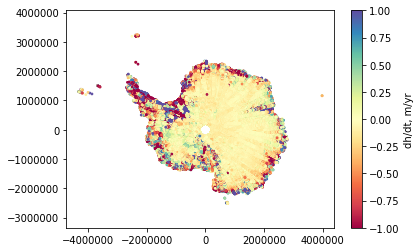

In [41]:
dhdt=(D11.h_corr[::10,-1]-D11.h_corr[::10,0])/((D11.delta_time[::10,-1]-D11.delta_time[::10,0])/sec_per_year)
#plt.figure(); 
plt.clf()
plt.scatter(D11.x[::10,0], D11.y[::10,0], 3, c=dhdt, cmap='Spectral', vmin=-1, vmax=1)
plt.axis('equal')
h_cb=plt.colorbar(); 
h_cb.set_label('dh/dt, m/yr')

The most efficient way to map a subset of Antarctica is plot only the subset of the D11 dhdt that corresponds to your region.  Here's PIG and Thwaites:

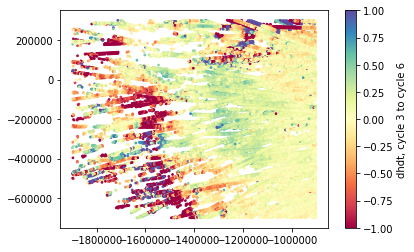

In [54]:
ctr_xy=(-1400.e3, -200.e3)
map_W=1000e3
subset=np.flatnonzero((np.abs(D11.x[:,0]-ctr_xy[0])< map_W/2) & (np.abs(D11.y[:,0]-ctr_xy[1]) < map_W/2))

# every point is still too much!
subset=subset[::5]
# recalculate dhdt
dhdt=(D11.h_corr[subset,-1]-D11.h_corr[subset,0])/((D11.delta_time[subset,-1]-D11.delta_time[subset,0])/sec_per_year)
plt.figure()
plt.scatter(D11.x[subset,0], D11.y[subset,0], 3, c=dhdt, cmap='Spectral', vmin=-1, vmax=1)
hb=plt.colorbar()
hb.set_label('dhdt, cycle 3 to cycle 6')